## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import random
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

import geopandas as gpd
import contextily as ctx

In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [4]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD
from pesuelogit.etl import data_curation, add_period_id

# Functions from internal modules
from nesuelogit.models import compute_generated_trips, compute_generation_factors,  \
    create_tvodlulpe_model_fresno, create_tvgodlulpe_model_fresno, compute_benchmark_metrics
from nesuelogit.etl import build_network, get_tensors_by_year
from nesuelogit.visualizations import  plot_predictive_performance, plot_top_od_flows_periods, \
    plot_utility_parameters_periods, plot_rr_by_period, plot_rr_by_period_models, plot_total_trips_models, \
    plot_performance_functions, plot_flow_vs_traveltime, plot_flow_interaction_matrix, \
    plot_convergence_estimates, plot_parameters
from nesuelogit.metrics import mse, mdape, r2_score, z2score
from nesuelogit.utils import read_paths, load_k_shortest_paths

### Hyperparameters

In [13]:
# Data
_DAYSOFWEEK = [1,2,3] # Monday:0, Sunday:6
_HOURS = np.arange(6,21)
# _HOURS = [6,7,8, 9, 15,16,17]
# _HOURS = np.arange(16,17)

# Optimization
_LOSS_WEIGHTS = {'tvodlulpe': {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1},
                 'tvgodlulpe': {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}}
_LR = {'tvodlulpe': {'learning': 1e-1, 'equilibrium': 5e-2},
       'tvgodlulpe': {'learning': 1e-1, 'equilibrium': 5e-2, 'generation': 2}}
_EPOCHS = {'tvodlulpe':{'learning': 10, 'equilibrium': 0},
           'tvgodlulpe':{'learning': 10, 'equilibrium': 0}}
_RELATIVE_GAP = 1e-3
_BATCH_SIZE = 1
_LOSS_METRIC  = z2score
_EVALUATION_METRIC = mdape

_OPTIMIZERS = {model: {key: tf.keras.optimizers.legacy.Adam(learning_rate=lr) for key, lr in lrs.items()} for model, lrs in _LR.items()}

In [6]:
# Seed for reproducibility
_SEED = 2024
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

# To report global runtime
t0_global = time.time()

# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 231217195530


## Read nodes and link-specific data

In [7]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

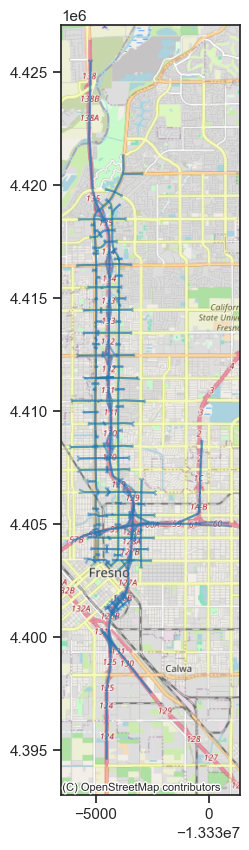

In [8]:
## Display network
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
ax = links_gdf.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

## Build Fresno network

In [9]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

## Read OD matrix

In [10]:
read_OD(network=network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read paths

In [11]:
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-fresno-k3.csv')
# read_paths(network=network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

#To generate K shortest paths and write in disk
# _K = 3
# load_k_shortest_paths(network=network, k=_K, theta = {'tt':-1}, update_incidence_matrices=True, block_output=False)
# write_paths(network.paths, filepath=f'input/network-data/fresno/paths/paths-fresno-k{_K}.csv')

20840 paths were read and incidence matrices were built


## Read spatiotemporal data

In [14]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period'], format = '%Y-%m-%d-%H').dt.strftime('%Y-%m-%d-%H')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday (1) to Thursday (3)
# df = df[df['date'].dt.dayofweek.isin(_DAYSOFWEEK)]
# Select data from one day only in 2019 and 2020
# df = df[df['date'].isin(["2019-10-01", "2020-10-06"])]

# # Select countdata from selected links
# selected_links = [(290,169,'0'),(170,168,'0'),(337,692,'0'),(228,192,'0'),(191,171,'0'),(188,87,'0'), (171,290,'0'),(192,191,'0'),(87,228,'0'),(169,332,'0'),(631,635,'0'),(179,183,'0'), (641,86,'0'),(638,634,'0'),(170,207,'0'),(86,189,'0'),(580,142,'0'),(333,332,'0'), (99,43,'0'),(637,639,'0')]
# df.loc[~df.link_key.isin(selected_links),'counts'] = float('nan')
# df.loc[~df.link_key.isin([(290,169,'0')]),'counts'] = float('nan')

In [15]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [16]:
df.head()

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_ids,link_type,id,...,median_age,incidents,bus_stops,intersections,date,hour,tf_inrix,year,period,period_id
0,"(0, 1621, 0)",0,NaN,1800.0,0.098,45,1.626616e+09,[],LWRLK,1,...,31.1,0,0,1,2019-10-01,10,0.221,2019,2019-10-01-10,4
1,"(1239, 1630, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,565,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
2,"(228, 192, 0)",1,1667.0,2400.0,0.110,65,1.626659e+09,[602350],LWRLK,564,...,16.6,0,0,0,2019-10-01,10,0.112,2019,2019-10-01-10,4
3,"(1243, 1631, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,563,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
4,"(1244, 1632, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,562,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4


In [17]:
# Units in miles per hour
df[['speed_ref_avg','speed_hist_avg','speed_max']].describe()

,speed_ref_avg,speed_hist_avg,speed_max
count,1.013460e+06,1.009583e+06,1.013460e+06
mean,1.924470e+01,1.767589e+01,2.051278e+01
std,1.982261e+01,1.909664e+01,2.140424e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.112700e+01,1.755400e+01,2.112700e+01
75%,2.796200e+01,2.547600e+01,3.106900e+01
max,6.772900e+01,7.891400e+01,8.388500e+01


In [18]:
df.columns

Index(['link_key', 'observed', 'counts', 'capacity [veh]', 'tt_ff [min]',
       'speed_ff[mi/hr]', 'inrix_id', 'pems_ids', 'link_type', 'id', 'rhoj',
       'lane', 'ff_speed', 'length', 'alpha', 'beta', 'tf', 'k', 'inrix_id.1',
       'speed_avg', 'speed_ref_avg', 'speed_hist_avg', 'tt_avg', 'speed_max',
       'speed_sd', 'speed_cv', 'speed_hist_sd', 'speed_ref_sd', 'tt_sd',
       'tt_var', 'tt_cv', 'road_closures', 'median_inc', 'median_age',
       'incidents', 'bus_stops', 'intersections', 'date', 'hour', 'tf_inrix',
       'year', 'period', 'period_id'],
      dtype='object')

## Data curation

In [19]:
df.loc[df['speed_ref_avg']<=0,'speed_ref_avg'] = float('nan')

df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

In [20]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [21]:
df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg','tt_sd_adj']].describe()

,speed_ref_avg,speed_hist_avg,tt_ff,tt_avg,tt_sd_adj
count,599370.000000,1.009583e+06,1.013460e+06,887813.000000,1.013460e+06
mean,32.540388,1.767589e+01,2.038423e-01,0.219493,3.022799e-04
std,15.223625,1.909664e+01,2.610045e-01,0.262030,4.638521e-04
min,8.078000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,24.233000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,26.719000,1.755400e+01,1.497376e-01,0.167050,1.856268e-04
75%,32.933000,2.547600e+01,2.792397e-01,0.312986,4.248116e-04
max,67.729000,7.891400e+01,4.220601e+00,3.827439,1.243267e-02


## Node data

In [22]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

In [23]:
features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
# scaler = preprocessing.MinMaxScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Utility function

In [24]:
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

## Data processing

In [25]:
n_links = len(network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [26]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1761.140959,0.204903,0.221931,0.200169,0.018137
std,770.228931,0.262226,0.266852,0.228208,0.027831
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1249.000000,0.000000,0.000000,0.000000,0.000000
50%,1686.000000,0.150455,0.168820,0.152000,0.011138
75%,2162.450000,0.282111,0.318261,0.280000,0.025489
max,4807.000000,4.220601,3.827439,2.302000,0.745960


In [27]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1605.127777,0.202618,0.216770,0.198494,0.018137
std,743.713869,0.259583,0.256512,0.226003,0.027831
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1108.450000,0.000000,0.000000,0.000000,0.000000
50%,1528.900000,0.149437,0.165341,0.150000,0.011138
75%,1978.000000,0.274658,0.306717,0.273000,0.025489
max,4766.000000,4.220601,3.274444,2.113000,0.745960


In [28]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

In [29]:
# This correlation should be positive
df[['counts','tt_avg']].corr()

,counts,tt_avg
counts,1.000000,0.055122
tt_avg,0.055122,1.000000


## EDA

In [30]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [31]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


### Link attributes

In [32]:
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06
mean,1.813680e-02,2.621913e+01,7.441093e-01,1.500207e-01,8.765023e-01
std,2.783112e-02,2.135738e+01,3.193143e+00,4.411927e-01,1.319496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.113761e-02,2.482100e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.548870e-02,4.168100e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,7.459602e-01,1.158930e+02,4.000000e+01,4.000000e+00,9.000000e+00


## Training and validation sets

In [33]:
_DTYPE = tf.float32

# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin(_HOURS)], features_Z = _FEATURES_Z,
                             links_keys=list(network.links_dict.keys()))

# Split in training and test sets
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

In [34]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

### Reference O-D matrix and trip generation vectors

In [35]:

q_historic = np.repeat(network.q.flatten()[np.newaxis, :], len(_HOURS), axis=0)

#Adjust historic O-D and historic trip generation

generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

reference_q = q_historic*np.tile(generation_factors.values,(q_historic.shape[1],1)).T

reference_g = compute_generated_trips(q = reference_q, ods= network.ods, n_nodes = len(network.nodes))

# Total trips tvodlulpe pesuelogit:
# Epoch 0: 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04
# Final epoch: 6.4e+04 6.6e+04 6.3e+04 7.8e+04 7.9e+04 7.9e+04
# Growth factor captures the difference between the reference OD at epoch 0 and the estimated OD.
growth_factor = 7.9/6.6
reference_g = growth_factor*reference_g
reference_q = growth_factor*reference_q

## Models

In [36]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

### TVODLULPE

In [ ]:
# To report runtime
t0 = time.time()

models['tvodlulpe'] = create_tvodlulpe_model_fresno(network = network, n_periods = n_periods,
                                                    # historic_q = models['tvodlulpe'].od.flat_od_from_trip_generation(reference_g),
                                                    historic_q = reference_q,
                                                    features_Z = _FEATURES_Z, dtype = _DTYPE)

train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= _OPTIMIZERS['tvodlulpe'],
    node_data=nodes_df,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS['tvodlulpe'],
    loss_metric= _LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS['tvodlulpe'])

print(f'runtime: {time.time()-t0:0.1f} [s]')

models['tvodlulpe'].save_weights(f"output/models/{ts}_fresno_tvodlulpe.h5")

In [ ]:
metrics_df = models['tvodlulpe'].compute_loss_metrics(
    metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
    X=XT_val, Y=YT_val).assign(dataset='validation')
metrics_df = pd.concat([metrics_df,
                        models['tvodlulpe'].compute_loss_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                            X=XT_train, Y=YT_train).assign(dataset='training'),
                        compute_benchmark_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                            Y_ref=YT_train, Y=YT_val).assign(dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])


In [ ]:
flow_range = range(0,6000,100)
sharey = False

fig, axs = plot_performance_functions(model = models['tvodlulpe'],
                                      network = network,
                                      marginal = False,
                                      #alpha=models['tvodlulpe'].performance_function.alpha,
                                      #beta=models['tvodlulpe'].performance_function.beta,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      # selected_links = np.random.choice(range(tntp_network.get_n_links()), 10, replace=False)
                                      )

# for ax in axs.reshape(-1):
#     ax.set_xlim(xmin=-10)
#     ax.set_ylim(ymin=-1)
#     ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvodlulpe.png')

plt.show()

In [ ]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['tvodlulpe'],
                           network=network,
                           marginal=True,
                           # alpha=models['tvodlulpe'].performance_function.alpha,
                           # beta=models['tvodlulpe'].performance_function.beta,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe'],
                        observed_traveltime=models['tvodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

plt.show()

In [ ]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=1, show_validation=True,
                            curves=['equilibrium'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=1, show_validation=True,
                            curves=['travel time', 'link flow'],
                            prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-tvodlulpe.png')

In [ ]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=1)

#ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
#ax.set_ylim(ymin=1e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvodlulpe.png')

plt.show()

In [ ]:
if models['tvodlulpe'].performance_function.type == 'bpr':

    plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                               xticks_spacing=5)
    plt.show()

    #sns.displot(plot_data, x="value", hue="parameter", multiple="stack", kind="hist", alpha=0.8, norm_hist=True)

    plot_data = pd.melt(pd.DataFrame({'alpha': models['tvodlulpe'].performance_function.alpha,
                                  'beta': models['tvodlulpe'].performance_function.beta}), var_name='parameter')

    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
    # sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha =0.8, ax = ax, binwidth = 0.5)

    try:
        sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5)
        plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvodlulpe.png')
        plt.show()
    except:
        print('Distribution plot could not be shown')

In [ ]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys = period_keys, period_feature='hour')

print(theta_df)
#print(theta_df.values)

plot_rr_by_period(models['tvodlulpe'],period_keys, model_key = 'tvodlulpe', period_feature='hour', rotation_xticks = 90)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
#     replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df['hour'] = theta_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvodlulpe'].period_dict.items()})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (5.55,6), hour_label = True, rotation_xticks = 90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvodlulpe.png')

plt.show()

In [ ]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvodlulpe'],
                          historic_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20,
                          join_points = True,
                          rotation_xticks = 90)

In [ ]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")

if models['tvodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

### TVGODLULPE

In [ ]:
print('\ntvgodlulpe: Time varying route choice utility and trip generation, and link specific parameters for performance functions')

# To report runtime
t0 = time.time()

models['tvgodlulpe'] = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                      historic_g = reference_g, historic_q = reference_q)

train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=nodes_df,
    optimizers= _OPTIMIZERS['tvgodlulpe'],
    batch_size=_BATCH_SIZE,
    loss_weights= _LOSS_WEIGHTS['tvgodlulpe'],
    loss_metric=_LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS['tvgodlulpe'])

print(f'runtime: {time.time()-t0:0.1f} [s]')

models['tvgodlulpe'].save_weights(f"output/models/{ts}_fresno_tvgodlulpe.h5")


tvgodlulpe: Time varying route choice utility and trip generation, and link specific parameters for performance functions

Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 6 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    v

In [ ]:
metrics_df = models['tvgodlulpe'].compute_loss_metrics(
    metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
    X=XT_val, Y=YT_val).assign(dataset='validation')
metrics_df = pd.concat([metrics_df,
                        models['tvgodlulpe'].compute_loss_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                            X=XT_train, Y=YT_train).assign(dataset='training'),
                        compute_benchmark_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                            Y_ref=YT_train, Y=YT_val).assign(dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])
print(f'runtime: {time.time()-t0:0.1f} [s]')

In [ ]:
selected_links = np.random.choice(range(network.get_n_links()), 20, replace=False)

#weights_interaction = models['tvgodlulpe'].performance_function.weights[1].numpy()
weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].kernel_matrix.numpy()
initial_weights_interaction = models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()
# Plot sign of values in flow interaction matrix
plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights_interaction,
    # flow_interaction_matrix=np.where(weights_interaction>0, 1, -1)*np.where(weights_interaction==0, 0, 1),
    # masking_matrix = np.where(initial_weights_interaction>0, 1, -1)*np.where(initial_weights_interaction==0, 0, 1),
    links_ids = selected_links + 1,
    # vmin = -0.05, vmax = 0.05
    vmin = -1, vmax = 1
)

plt.savefig('output/figures/results/fresno-kernel-link-performance-functions-tvgodlulpe.png')

plt.show()

print(f'Final weights interaction:\n {weights_interaction}')
print(f'\nInitial weights interaction:\n',initial_weights_interaction)

# non_diagonal_mlp_weights = weights[~np.eye(weights.shape[0], dtype=bool)]
# print(f"Percentage of non-diagonal terms that are non-positive: {len(non_diagonal_mlp_weights[(non_diagonal_mlp_weights<=0)])/len(non_diagonal_mlp_weights):.2%}")

# non_zero_elements = weights_interaction[np.where(models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()>0)]
# print(f"Percentage of non-zero terms that are positive: {len(non_zero_elements[(non_zero_elements>0)])/len(non_zero_elements):.2%}")

In [ ]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['tvgodlulpe'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

try:
    sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8,
                facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5) # , col="parameter"
    plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvgodlulpe.png')
    plt.show()
except:
    print('Distribution plot could not be shown')

plot_data['value_abs'] = plot_data.value.abs()

print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [ ]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['tvgodlulpe'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

In [ ]:
flow_range = range(0,5000,100)
sharey = False

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = False,
                           alpha= 0.15,
                           beta= 4,
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvgodlulpe.png')

plt.show()

In [ ]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = True,
                           selected_links = selected_links,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )
plt.show()

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = models['tvgodlulpe'],
                        observed_traveltime=models['tvgodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvgodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

# for ax in axs.reshape(-1):
#     ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-tvgodlulpe.png')

plt.show()

In [ ]:
plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=1, show_validation=True,
                            curves=['equilibrium'])

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=1, show_validation=True,
                            curves=['travel time', 'link flow'],
                            prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-tvgodlulpe.png')

In [ ]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvgodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvgodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=1)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvgodlulpe.png')

plt.show()

In [ ]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys = period_keys, period_feature='hour')
#print(theta_df.values)

plot_rr_by_period(models['tvgodlulpe'], period_keys, model_key = 'tvgodlulpe', period_feature='hour', rotation_xticks = 90)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvgodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

# Plot parameters by period
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

kappa_df = pd.concat([pd.DataFrame({'period': [period], 'parameter': [feature], 'value': [models['tvgodlulpe'].kappa[period, i].numpy()]}) for period in range(models['tvgodlulpe'].kappa.shape[0]) for i, feature in enumerate(models['tvgodlulpe'].generation.features)]).assign(group = 'generation')

parameters_df = pd.concat([theta_df, kappa_df]).\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income', 'rr': 'reliability ratio'})

parameters_df['hour'] = parameters_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvgodlulpe'].period_dict.items()})

fig, ax = plot_parameters(df = parameters_df[parameters_df.group == 'utility'], n_cols_legend = 3, figsize = (5.7,6), hour_label = True, rotation_xticks = 90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvgodlulpe.png')

plot_parameters(df = parameters_df[parameters_df.group == 'generation'], n_cols_legend = 3, figsize = (5.5,6), hour_label = True, rotation_xticks = 90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-generation-periods-tvgodlulpe.png')

plt.show()

print('Theta:', models['tvgodlulpe'].theta.numpy().T)
print('Kappa:', models['tvgodlulpe'].kappa.numpy().T)

In [ ]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvgodlulpe'],
                          historic_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20,
                          join_points = True, rotation_xticks = 90)

In [ ]:
print(f"theta = "
      f"{dict(zip(models['tvgodlulpe'].utility.true_values.keys(), list(np.mean(models['tvgodlulpe'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['tvgodlulpe'].generation.features, list(np.mean(models['tvgodlulpe'].kappa.numpy(), axis=0))))}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvgodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

## Write estimation results

In [ ]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{ts}_train_results_{network.key}.csv"
val_filename = f"{ts}_validation_results_{network.key}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

## Summary of parameter estimates

### All models

In [ ]:
models

In [ ]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [ ]:
print(results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4))

### TVGODLULPE

In [ ]:
# Stats by period
model = models['tvgodlulpe']

with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('theta:', pd.DataFrame(model.theta.numpy().T))

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('kappa:', pd.DataFrame(model.kappa.numpy().T))

In [ ]:
# with pd.option_context('display.float_format', '{:0.1f}'.format):
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('OD matrix', pd.DataFrame({'od_mean': np.mean(model.q,axis = 1), 'od_std': np.std(model.q, axis = 1), 'od_total':np.sum(model.q,axis = 1)}).T)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS[model_key]['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(results_losses[['model'] + list(results_losses.columns)])

## Plot of convergence toward true rr across models

In [ ]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])

    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
#estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

# ax.hlines(y=compute_rr(models.popitem().true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 2, 1))

#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Plot of reliability ratio by hour for all models

In [ ]:
reliability_ratios = plot_rr_by_period_models(models, period_keys, period_feature='hour', join = True, rotation_xticks = 90)

plt.savefig('output/figures/results/fresno-reliability-ratios-periods.png')

plt.show()

In [ ]:
print(reliability_ratios)

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(reliability_ratios[reliability_ratios.model == 'tvgodlulpe'][['hour','rr']].T)

In [ ]:
print(reliability_ratios.groupby('model')[['rr']].mean().round(4))

## Plot of total trips by hour for all models

In [ ]:
total_trips = plot_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys,
                                      historic_od = network.q.flatten(), join = True, rotation_xticks = 90)

plt.savefig('output/figures/results/fresno-total-trips-periods.png')

plt.show()

In [ ]:
print(total_trips)

In [ ]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

In [ ]:
total_trips.groupby('model')[['total_trips']].sum().round(1)



## Global runtime

In [ ]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')